In [1]:
# Import modules and make matplotlib plot inline
import numpy as np
import matplotlib.pyplot as plt
import emcee
%matplotlib inline  

# 1. Read in our sample dataset and visualize it with matplotlib

In [2]:
x,y,y_err = np.loadtxt('../sample_data.csv',delimiter=',',unpack=True)

In [3]:
# Check that we read in reasonable values
print(x)
print(y)
print(y_err)

[0. 1. 2. 6. 9.]
[51.98 49.88 55.17 73.97 82.81]
[2.7 1.8 0.9 5.4 4.5]


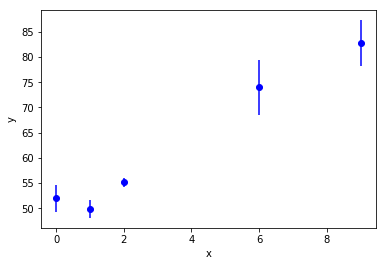

In [4]:
# Let's visualize it
plt.figure()
plt.errorbar(x,y,yerr=y_err,fmt='bo');
plt.xlabel('x');
plt.ylabel('y');

# 2. Creating a model
It looks like a line would be a reasonable model for this data. In reality, you would have more information about the dataset so you might choose a model based on physics or other reasoning. But here, let's continue this example with just fitting a line.

First, it is helpful to define a python function that computes model `y` values for given parameter values and input `x` data points. Here's a skeleton for you to write your own function to compute the model. `params` should be an array of model parameters, perhaps `[slope, intercept]`, and `x` should be an array of the actual `x` points where you want to compute the model values. Your function should return the model values in `model_values`.

Note: In general, these functions you define should be as efficient as possible. They may be called thousands or millions of times in an MCMC run!

In [5]:
# Define your model
def compute_model(params,x):
    # Compute model_values here
    slope,intercept = params
    model_values = intercept + slope*x
    return model_values

## Test your model
Although not necessary, it's always good to make sure you didn't choose something ridiculuous for your model or you didn't make some mistake.

In [6]:
# Compute the model guess
params_guess = [5,45] # slope, intercept guess
x_arr = np.linspace(0,10,11) # an array of 11 elements from 0 to 10, for plotting
# Compute model values
model_arr = compute_model(params_guess,x_arr)

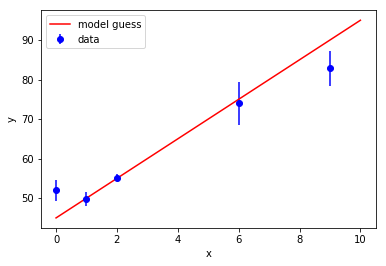

In [7]:
# Plot the data and model guess
plt.figure()
plt.errorbar(x,y,yerr=y_err,fmt='bo',label='data'); # plot the data
plt.plot(x_arr,model_arr,'r-',label='model guess'); # plot the model guess
plt.legend()
plt.xlabel('x');
plt.ylabel('y');

Not bad! :)

# 3. Construct the log likelihood function
Next, let's define a python function that will return the value of the likelihood, i.e. the probability of measuring the dataset given the model parameters, `prob(data|model)`. However, during these computations, you may be comparing very small differences in probabilities, resulting in errors due to numerical underflow. So, it is much easier to work with (natural) logarithms of probabilities instead. 

Below, fill in the cell to complete the function. You will return the natural log of the likelihood probability. For use with `emcee`, the first argument must be the array of parameters. The other arguments you will need to pass will be your data. Here, let's assume the data are measured so that the x points have no errorbars and the y points have Guassian errorbars. Also, let's assume each data point is independently measured.

Note: I would recommend using a call to `get_model` that you defined above so that if you do want to change the model, you can just swap out a different function. However, you can of course just compute the model again inside this function. And as before, this function will be called thousands to millions (or more) times, so think about efficiency (i.e. avoid loops! take advantage of vectorized methods).

In [8]:
# Define your likelihood function
def get_ln_like(params,x,y,yerr):
    # fill in your function here
    model_y = compute_model(params,x)
    chi_squared = np.sum((y-model_y)**2.0 / y_err**2.0)
    ln_like = -0.5*chi_squared
    return ln_like

# 4. Construct the log prior function
The next step is to define a python function that returns the value of the prior probability, i.e. the probability of a given model being true, `prob(model)`. Again, it is easier to work with logarithms of probabilities.

Let's start with an uninformed (uniform) prior. Fill in the cell below to create a function that returns the value of the prior probability for various models. Note that these probabilities do not depend on the dataset at all, the only input you need is the model parameters, which is why these are "prior" probabilities, i.e. before you consider any data.

Hint: Although a true uninformed prior would encompass all real values, it is not really practical to compute infinite ranges. So, as discussed in today's session, pick upper/lower limits on the range of the two model parameters.

Note: For this exercise, please do ensure your returned prior value is normalized so that the sum over all possible adds up to one. But, note that in practice, this is not really necessary because in today's session, we are only interested in relative posterior probabilities.

In [9]:
# Define uninformed prior
def get_ln_prior(params):
    # fill in your function here
    
    slope, intercept = params
    
    # Compute prior from the slope parameter
    min_slope=0
    max_slope=15
    # Check if slope within above range
    if slope < min_slope or slope > max_slope: # Not in range, return ln(0)
        ln_prior_slope = -np.inf 
    else: # within range, return 1/(max-min)
        ln_prior_slope = np.log(1.0/(max_slope-min_slope))
    
    # Compute prior from the intercept parameter
    min_intercept=30
    max_intercept=70
    if intercept < min_intercept or intercept > max_intercept: # Not in range, return ln(0)
        ln_prior_intercept = -np.inf 
    else: # within range, return 1/(max-min)
        ln_prior_intercept = np.log(1.0/(max_intercept-min_intercept))
    
    # Compute the joint prior
    ln_prior = ln_prior_slope + ln_prior_intercept
    
    return ln_prior

# 5. Construct the log posterior function
Finally, we can calculate the posterior probability, which is our actual goal: the probability of the model given the data and priors, i.e. `prob(model|data) ~ prob(data|model) * prob(model)`.

Again, we want to work in log space. We will need to compute `ln_like` and the `ln_prior` so we need both the `params` array and all of the dataset. Fill in the cell below to compute the `ln_post` from `ln_like` and `ln_prior`, using your functions defined above.

In [10]:
# Define posterior
def get_ln_post(params,x,y,yerr):
    # fill in your function here
    ln_like = get_ln_like(params,x,y,yerr)
    ln_prior = get_ln_prior(params)
    ln_post = ln_like + ln_prior
    return ln_post

## Test it out!
Let's just plug in some numbers to see if we're getting results that make sense. In the cell below, change the initial guess around to have some good guesses and bad guesses and see that when the fit goes bad, the posterior probability decreases. Run the cell after each guess.

Be sure to try some guesses outside of whatever range you defined as your prior above.

ln_like  = -23.007, like prob  = 1.0186341469648437e-10
ln_prior = -6.397, prior prob = 0.0016666666666666668
ln_post  = -29.404, post prob  = 1.6977235782747366e-13


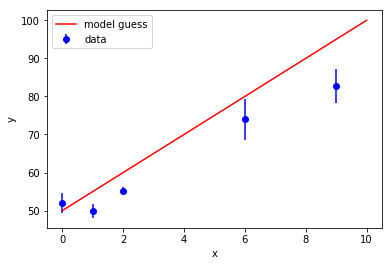

In [11]:
# Compute the model guess
params_guess = [5,50] # slope, intercept guess: CHANGE THIS
x_arr = np.linspace(0,10,11) # an array of 11 elements from 0 to 10, for plotting
model_arr = compute_model(params_guess,x_arr)
# Plot the data and model guess
plt.figure()
plt.errorbar(x,y,yerr=y_err,fmt='bo',label='data'); # plot the data
plt.plot(x_arr,model_arr,'r-',label='model guess'); # plot the model guess
plt.legend()
plt.xlabel('x');
plt.ylabel('y');
# Print the likelihood, prior, and posterior for the guess
ln_like  = get_ln_like(params_guess,x,y,y_err)
ln_prior = get_ln_prior(params_guess)
ln_post  = get_ln_post(params_guess,x,y,y_err)
print('ln_like  = {:+.3f}, like prob  = {}'.format(ln_like,np.exp(ln_like)))
print('ln_prior = {:+.3f}, prior prob = {}'.format(ln_prior,np.exp(ln_prior)))
print('ln_post  = {:+.3f}, post prob  = {}'.format(ln_post,np.exp(ln_post)))

# 6. Sampling the posterior with MCMC

## Brute force won't work!
In the preceding steps, we see that we can use Bayes Theorem to calculate the posterior because we know how to calculate the likelihood and we get to choose the prior. In the final step above, we have a little piece of code that can tell us the posterior for any pair of model parameters. So, naively, if we wanted to sample the posterior and map it out, we can do this with brute force! That is, we can set up a fine grid for each of the two parameters and meticulously step through each grid point, calculate the posterior and write it down. If we do this (or get a computer to do this and plot it), we can draw a map of the posterior! However, this is not very efficient at all. It may be doable with just two dimensions and a small range of valid parameter values. But this will eventually require N^M calculations, where N is the number of grid points per parameter and M is the number of parameters. A coarse grid of just 50 points is already over 6 million calcualtions with only 4 parameters!

## A smarter way: MCMC with `emcee`
As mentioned before, MCMC is a smarter way to compute the posterior. We want to be spending our time computing the posterior ("sampling") in areas of high probability, not the entire grid which will mostly be empty. Here, we will be implementing the `emcee` sampler. For this exercise, we won't look into the black box and just focus on getting results. For more information on this package, check out: http://dfm.io/emcee/current/

In [12]:
# Import the package
import emcee

### Set up the EnsembleSampler object
To set up the emcee EnsembleSampler object, we need to tell it how many dimensions we're working in and how many walkers to use to explore the parameter space. The number of dimensions, `ndim` is just the number of parameters. Each walker starts at an initial guess and using the black box algorithm, explores the posterior space and collects samples. This is an "EnsembleSampler" because each walker is a member of the "Ensemble", so the combination of samples from all the walkers will constitute our final MCMC "chain". The number of walkers, `nwalkers` should be even and at least twice the number of dimensions. Typically, a large number such as 100 is a good choice, maybe more for more complicated problems.

In [13]:
# Set up the emcee sampler
ndim=2
nwalkers=100

We will be using the `emcee.EnsembleSampler` object, which takes 3 required arguments plus some optional ones. The three required arguments, in order, are the number of walkers, the number of dimensions, and a function that takes a vector of parameters as input and returns the log of the posterior probability (i.e. what we did above). There are also some optional arguments, we will be using the `args` optional argument in order to pass additional arguments to the posterior function (by default, `emcee` will only pass it the vector of model parameters).

For more on what you can do, check out the API: http://dfm.io/emcee/current/api/

In [14]:
# Construct the EnsembleSampler object using the posterior
sampler = emcee.EnsembleSampler(nwalkers, ndim, get_ln_post, args=[x,y,y_err])

### Run the sampler from an initial guess
Now, we just have to start drawing samples! We must first start with an initial point for all 100 walkers. This looks like 100 pairs of `(slope,intercept)` points in this case. In general, it should have shape `(nwalkers,ndim)`. `emcee` provides a utility that generates a ball of points around some initial guess with some standard deviation you provide. The following line creates an initial point for all walkers centered on a slope of 5.0, an intercept of 45 and standard deviations of 2.0 for the slope and 10 for the intercept.

In [15]:
# Initital position of walkers
p0 = emcee.utils.sample_ball((5.0,45),(2.0,10),nwalkers)

In [16]:
# Now, run the sampler for 1000 steps (100,000 samples in total), starting from this initial position
sampler.run_mcmc(p0,1000);

//anaconda/envs/emcee_workshop/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
//anaconda/envs/emcee_workshop/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


### Analyse results of MCMC run
Now that we have our 100,000 samples, let's take a look at time and make some calculations / do some analysis. The `sampler` object contains some useful attributes. First, the `chain` attribute (`sampler.chain`) has shape `(nwalkers,nsteps,ndim)` which allows you to see the value for each dimension/parameter at each step for each walker. For statistics including all the walkers, it is more useful to use `sampler.flatchain` which flattens out the `nwalkers` dimension, so it just has shape `(nsteps,ndim)`. In the way we set up our problem, the first dimension is the slope while the second dimension is the intercept. So, we can plot histograms and calculate some values from the samples of these two parameters

Median and stddev for slope are: 3.835 +/- 0.548
Median and stddev for intercept are: 47.701 +/- 1.438


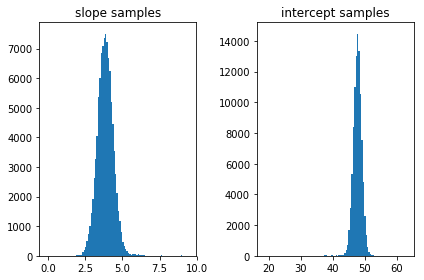

In [17]:
# Example of how to get the samples for individual parameters
slopes = sampler.flatchain[:,0] # all 100,000 samples of slope
intercepts = sampler.flatchain[:,1] # all 100,000 samples of intercept
# Calculate and print median and standard deviation, representing 50th percentile value and the "spread"
median_values = np.median(sampler.flatchain,axis=0)
slope_median, intercept_median = median_values
stddev_values = np.std(sampler.flatchain,axis=0)
slope_std, intercept_std = stddev_values
print('Median and stddev for slope are: {:.3f} +/- {:.3f}'.format(slope_median,slope_std))
print('Median and stddev for intercept are: {:.3f} +/- {:.3f}'.format(intercept_median,intercept_std))
# Now plot the histograms
plt.figure()
plt.subplot(1,2,1)
plt.hist(slopes,bins=100);
plt.title('slope samples')
plt.subplot(1,2,2)
plt.hist(intercepts,bins=100);
plt.title('intercept samples')
plt.tight_layout();

The above plots are a demostration of what is in the chain object. The author of `emcee` also wrote a program called `corner` to plot the distributions of the samples as a matrix of pairwise correlations that make it easier to visualize the results. 

In [18]:
# Import corner
import corner

Using corner is easy, just supply it with the `flatchain` object for a quick look. Below, there are some optional parameters added for some details. You can see all your options by checking out the corner.py API: https://corner.readthedocs.io/en/latest/api.html

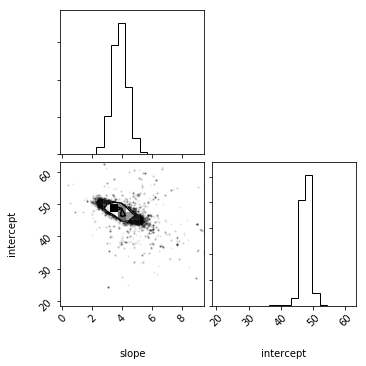

In [21]:
corner.corner(sampler.flatchain, labels=['slope','intercept']);

To better display the samples, you can use the `range` argument to choose the limits on the plots (Note: This doesn't change your MCMC output, just how this set of plots is displayed!)

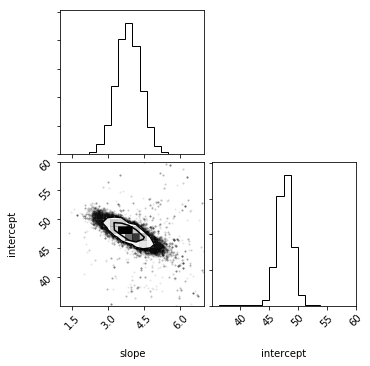

In [27]:
corner.corner(sampler.flatchain, labels=['slope','intercept'], range=((1,7),(35,60)));

Another useful argument is `truths` which draws crosshairs over whatever values you want (here, we do the medians)

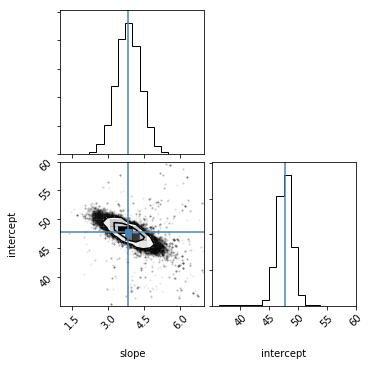

In [28]:
# Add in some lines for the median values "truths"
corner.corner(sampler.flatchain, labels=['slope','intercept'], range=((1,7),(35,60)), truths=median_values);

For the last corner.py demostration, let's add lines for other quantiles. For instance, we can draw lines on the histograms for the 16th percentile and the 84th percentile. These quantiles encompass 68% of the probability, so they are representative of the 68% confidence interval centered on the median.

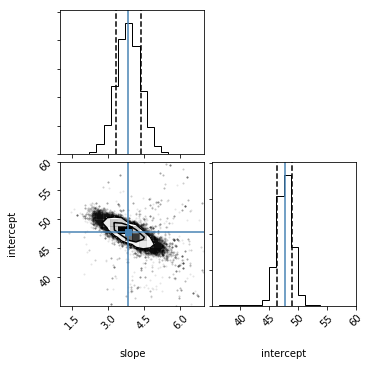

In [31]:
# Add more lines for the 16th and 84th percentiles
corner.corner(sampler.flatchain, labels=['slope','intercept'], range=((1,7),(35,60)), truths=median_values, quantiles=[0.16,0.84]);

Finally, maybe you are interested in the most likely value rather than the median. Often, in Bayesian infernece, the most likely value does not have much meaning as we are more interested in the overall distribution of the posterior. 

When you have a Gaussian posterior, like we do here, the median is also the most likely value ("best fit"). But in general, we can find the most likely value by finding the highest value in the `sampler.flatlnprobability` array and getting the corresponding entry in `sampler.flatchain`. Try to do this below. Hint: Use `np.argmax()`

In [37]:
# Find the most likely value from MCMC chain
slopes = sampler.flatchain[:,0] # all samples of slope
intercepts = sampler.flatchain[:,1] # all samples of intercept
step_max = np.argmax(sampler.flatlnprobability) # The step in the chain with the highest post. probabiblity
# Print out the answers
print('The most likely slope is {:.3f}'.format(slopes[step_max]))
print('The most likely intercept is {:.3f}'.format(intercepts[step_max]))

The most likely slope is 3.836
The most likely intercept is 47.679


### Final MCMC remarks
Now you have the basic framework for implementing `emcee`. Because you have written all the code to be modular, you can swap out each function to meet your own research needs. You'd load up your own data. You can redefine the model function to be whatever model you are trying to use. You can change how the priors are defined. You can modify the `emcee.EnsembleSampler` setup to match your research question!

**Optional exercise:** Go back and modify the prior to be something really restrictive and see how the posteriors turn out!

# 7. Comparison with other methods
With a least squares fit for a line, there is actually an analytical solution. It's not in the scope of this workshop, but you can check out Section X.X in Sivia, or just Google it :) 

There is also a way to numerically solve for the most likely value by using `scipy.optimize` routines on the `lnlike` or `lnpost` functions above, giving you the maximum likelihood estimate and the maximum a posteriori (MAP) estimate, respectively. The difference between the two is whether or not to include the prior. These methods are estimates for the mode of the likelihood and posterior pdfs.

In [38]:
# Import scipy's optimization module
import scipy.optimize as op

All of these numerical methods actually find minimums, not maximums. So, using the `lambda` notation, we can quickly create anonymous functions that returns the negative log likelihood and negative log posterior for this part. Then, we use `scipy.opitmize.minimize` with an initial guess for parameters (5,45) and pass it the data. The results are stored in the `results` object and the attribute corresponding to the most likely parameters is `x`.

In [39]:
neglnlike = lambda *args: -get_ln_like(*args)
result = op.minimize(neglnlike, [5,45], args=(x, y, y_err))
slope_maxlike, intercept_maxlike = result["x"]
print('Max likelihood estimates for slope     = {:.3f}'.format(slope_maxlike))
print('Max likelihood estimates for intercept = {:.3f}'.format(intercept_maxlike))

Max likelihood estimates for slope     = 3.832
Max likelihood estimates for intercept = 47.690


Another useful attribute from `result` is `result['hess_inv']`. The inverse Hessian is basically a covariance matrix. If you are not familiar with these, one useful piece of info is that if you read off the diagonals, you are getting the variances (square of standard deviation) for the model parameters, so you can estimate the spread of your posterior on each parameter by taking the square root of the diagonals.

In [40]:
print(result['hess_inv'])

[[ 0.26177295 -0.50868632]
 [-0.50868632  1.555371  ]]


Compare the following to the MCMC results.

In [41]:
max_like_stddevs = np.sqrt(np.diag(result['hess_inv']))
slope_stddev_maxlike, intercept_stddev_maxlike = max_like_stddevs
print('Max likelihood estimate results:')
print('Slope:     {:.3f} +/- {:.3f}'.format(slope_maxlike,slope_stddev_maxlike))
print('Intercept: {:.3f} +/- {:.3f}'.format(intercept_maxlike,intercept_stddev_maxlike))

Max likelihood estimate results:
Slope:     3.832 +/- 0.512
Intercept: 47.690 +/- 1.247


### Maximum a posteriori (MAP) estimates
Since our priors are uniform, they don't really influence the posterior, so we expect the answer to be the same.

In [45]:
neglnpost = lambda *args: -get_ln_post(*args)
result_MAP = op.minimize(neglnpost, [5,45], args=(x, y, y_err))
slope_MAP, intercept_MAP = result_MAP["x"]
MAP_stddevs = np.sqrt(np.diag(result_MAP['hess_inv']))
slope_stddev_MAP, intercept_stddev_MAP = MAP_stddevs
print('Maximum a posteriori results:')
print('Slope:     {:.3f} +/- {:.3f}'.format(slope_MAP,slope_stddev_MAP))
print('Intercept: {:.3f} +/- {:.3f}'.format(intercept_MAP,intercept_stddev_MAP))

Maximum a posteriori results:
Slope:     3.832 +/- 0.512
Intercept: 47.690 +/- 1.247


### Helpful hint: Using maximum likelihood or maximum a posteriori estimates with MCMC
For complicated problems where you cannot just "eyeball" an initial guess, you can start your MCMC from your maximum likelihood/posterior value and use the covariance matrix to compute a good standard deviation to intialize your ball of walker starting points.